In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import string
import re

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

import datetime as dt
from tqdm.notebook import tqdm

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras import datasets

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
x_train[99].shape

(28, 28)

In [31]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28, 1)


In [32]:
x_test = x_test.reshape(-1,28,28,1) #grayscale image ie -->1
x_train = x_train.reshape(-1,28,28,1)

Text(0.5, 1.0, '6')

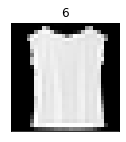

In [33]:

plt.figure(figsize=(6,2))
plt.imshow(x_train[499].reshape(28,28) , cmap = 'gray' )
plt.xticks([])
plt.yticks([])
plt.title(np.str_(y_train[499]))

In [34]:
# np.where(y_train==1)
train_groups = [x_train[np.where(y_train == i)] for i in np.unique(y_train)]

test_groups = [x_test[np.where(y_test == i)] for i in np.unique(y_test)]

In [35]:
def get_divisors(n):
    divs = [1]
    for i in range(2,int(np.sqrt(n))+1):
        if n%i == 0:
            divs.extend([i,n/i])
    divs.extend([n])
    return sorted(list(set(divs)))

In [36]:
def plot_img(images=[],title=""):
  plt.close()
  plt.figure(figsize=(9,9))
  r_c = get_divisors(len(images))
  for _,img in enumerate(images):
    plt.subplot( int(r_c[1]) , int(r_c[-2]) , _+1)
    plt.imshow(img.reshape(28,28) , cmap = 'gray' )
    plt.xticks([])
    plt.yticks([])
    plt.title(np.str_(title))
  plt.show()

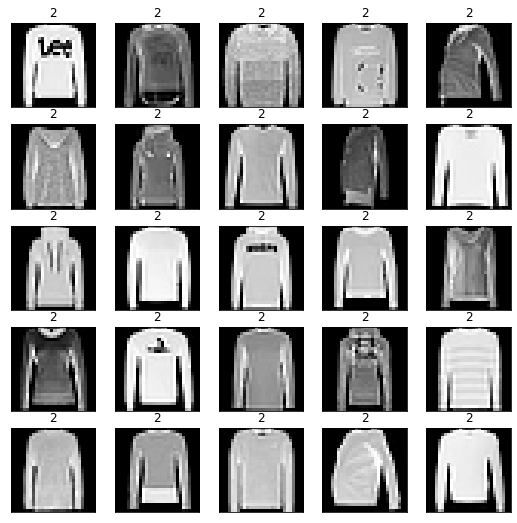

In [37]:
plot_img(test_groups[2][0:25],"2")

In [38]:
print([grp.shape[0] for grp in train_groups])
print([grp.shape[0] for grp in test_groups])

[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


#Generate Batches

In [39]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,axis = 0), np.stack(out_img_b,axis = 0), np.stack(out_score,axis = 0)

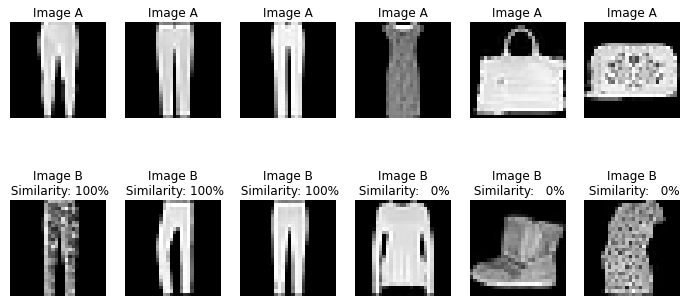

In [41]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0],cmap='gray')
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0], cmap='gray')
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

#Featurization

In [42]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

In [43]:
 x_train.shape[1:]

(28, 28, 1)

In [44]:
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 

In [46]:
from keras.layers import concatenate

In [47]:
#Siamese
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 32)           25040       ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationM

In [48]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

For a Dumb model : with random weight init

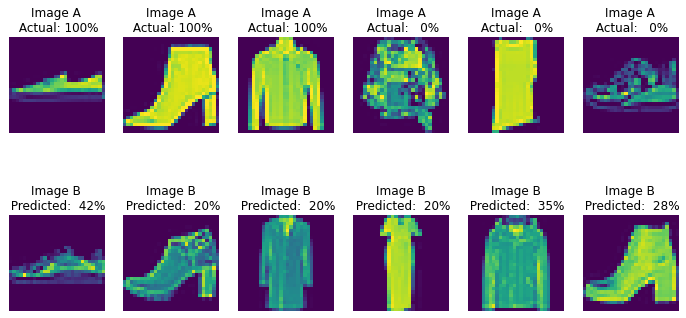

In [49]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

Generator

In [50]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 30s 55ms/step - loss: 0.7058 - mae: 0.4936 - val_loss: 0.5915 - val_mae: 0.4343
Epoch 2/10
500/500 [==============================] - 27s 54ms/step - loss: 0.5820 - mae: 0.4201 - val_loss: 0.4410 - val_mae: 0.2990
Epoch 3/10
500/500 [==============================] - 27s 54ms/step - loss: 0.4773 - mae: 0.3323 - val_loss: 0.3920 - val_mae: 0.2581
Epoch 4/10
500/500 [==============================] - 27s 55ms/step - loss: 0.4151 - mae: 0.2831 - val_loss: 0.3676 - val_mae: 0.2365
Epoch 5/10
500/500 [==============================] - 27s 54ms/step - loss: 0.4022 - mae: 0.2640 - val_loss: 0.3392 - val_mae: 0.2144
Epoch 6/10
500/500 [==============================] - 27s 54ms/step - loss: 0.3831 - mae: 0.2521 - val_loss: 0.3414 - val_mae: 0.2107
Epoch 7/10
500/500 [==============================] - 27s 54ms/step - loss: 0.3771 - mae: 0.2451 - val_loss: 0.3299 - val_mae: 0.2021
Epoch 8/10
500/500 [==============================] - 27s 54ms

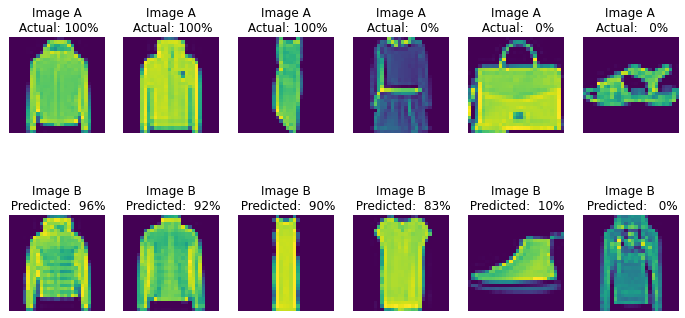

In [52]:
_ = show_model_output()